In [1]:
import limbo
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

%matplotlib notebook

DATA_DIR = 'data'

In [2]:
files = sorted(glob.glob(os.path.join(DATA_DIR, '*.dat')))
#print(files)
filename = files[-1]
#block = 425
block = 301
hdr, data = limbo.io.read_file(filename, nspec=4096, skip=block*4096)
hdr

{'fpg': 'limbo_500_2022-12-03_1749.fpg',
 'Time': 1674855102.729957,
 'AccLen': 127,
 'AdcCoarseGain': 4,
 'FFTShift': 2047,
 'Scaling': 0,
 'SpecCoeff': 4,
 'AdcDelay0': 5,
 'AdcDelay1': 5,
 'AdcDelay2': 5,
 'AdcDelay3': 5,
 'AdcDelay4': 5,
 'AdcDelay5': 5,
 'AdcDelay6': 5,
 'AdcDelay7': 5,
 'filename': 'data/Spectra_20230127233951.dat',
 'sample_clock': 500000000.0,
 'freqs': array([1.35000000e+09, 1.35012207e+09, 1.35024414e+09, ...,
        1.59963379e+09, 1.59975586e+09, 1.59987793e+09]),
 'inttime': 0.001040384,
 'nspec': 1744896,
 'times': array([1.67485510e+09, 1.67485510e+09, 1.67485510e+09, ...,
        1.67485511e+09, 1.67485511e+09, 1.67485511e+09]),
 'jds': array([2459972.39702234, 2459972.39702235, 2459972.39702236, ...,
        2459972.39707162, 2459972.39707164, 2459972.39707165]),
 'date': '2023-01-27 21:31:42'}

<IPython.core.display.Javascript object>


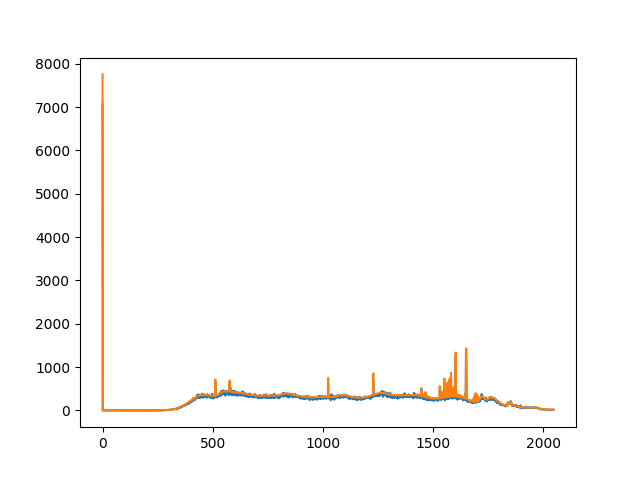

In [3]:
plt.figure()
plt.plot(data[0])
plt.plot(np.mean(data, axis=0) + np.mean(data, axis=0) / np.sqrt(hdr['AccLen']))

In [4]:
#np.savez('bandpass_v002.npz', freqs=hdr['freqs'], mdl=fmdl)
if False:
    import hera_filters
    CH0, CH1 = 400, 400+1024
    freq_filter = {'filter_centers': [0, 830e-9, -830e-9],
                     'filter_half_widths': [400e-9, 100e-9, 100e-9],
                     'eigenval_cutoff': [1e-9] * 3} 
    freq_amat, _ = hera_filters.dspec.dpss_operator(hdr['freqs'], **freq_filter)
    NSIG = 10
    fmdl = bandpass['mdl']
    spec = np.mean(data, axis=0)
    amp = np.median(spec[CH0:CH1] / fmdl[CH0:CH1])
    diff = spec - amp * fmdl
    nos = amp * fmdl / (hdr['AccLen'] * data.shape[0])**0.5
    fmask = diff / nos < NSIG
    np.savez('freq_mask_v001.npz',
             freqs=hdr['freqs'],
             mask=fmask,
             amat=freq_amat,
             fmat=hera_filters.dspec.fit_solution_matrix(np.diag(fmask.astype('float')), freq_amat),
             **freq_filter,
    )
freq_mask = np.load('freq_mask_v001.npz')
fmask = freq_mask['mask']
freq_amat = freq_mask['amat']
freq_fmat = freq_mask['fmat']

In [5]:
sim_frb = limbo.sim.make_frb(hdr['times'], hdr['freqs'], DM=331, pulse_width=0.12e-3, pulse_amp=25, t0=hdr['times'][500])
bandpass = np.load('bandpass_v002.npz')

In [6]:
def dpss_filter(y, amat, fmat):
    '''Apply the provided DPSS filter matrices to data.'''
    model = amat @ (fmat @ y)
    return model.real

if False:
    import hera_filters
    time_filter = {'filter_centers': [0, 42, -42],
                     'filter_half_widths': [2, 15, 15],
                     'eigenval_cutoff': [1e-9] * 3} 
    time_amat, _ = hera_filters.dspec.dpss_operator(hdr['times'], **time_filter)
    time_fmat = hera_filters.dspec.fit_solution_matrix(np.diag(np.ones_like(hdr['times'])), time_amat)
    np.savez('time_filt_v001.npz', amat=time_amat, fmat=time_fmat, **time_filter)
time_filt = np.load('time_filt_v001.npz')
time_amat = time_filt['amat']
time_fmat = time_filt['fmat']

In [34]:
import tqdm
hi_dms = []
#for block in tqdm.tqdm(range(50, 150)):
for block in [150+57]:
#for block in tqdm.tqdm(range(150, 250)):
    hdr, data = limbo.io.read_file(filename, nspec=4096, skip=block*4096)
    data = data #+ sim_frb * (bandpass['mdl'] / bandpass['mdl'].max())
    spec = np.mean(data, axis=0)
    fmdl = dpss_filter(spec * fmask.astype('float'), freq_amat, freq_fmat)
    tgain = np.sum(data[:,fmask], axis=1, keepdims=False) / np.sum(fmdl[fmask])
    tnos = np.sqrt(np.median(np.abs(tgain - 1)**2))  # XXX not really std
    tmask = (tgain - 1) / tnos < 4 # XXX not really std
    tgain[~tmask] = 1
    tmdl = dpss_filter(tgain, time_amat, time_fmat)
    mdl = np.outer(tmdl, fmdl)
    nos = mdl / hdr['AccLen']**0.5
    diff_dat = data - mdl
    full_mask = np.where(diff_dat > 6 * nos, 0, 1)
    full_mask[:, ~fmask] = 0
    full_mask[~tmask] = 0
    diff_dat *= full_mask
    CH0, CH1 = 400, 400+1024
    fdmt = limbo.fdmt.FDMT(hdr['freqs'][CH0:CH1], hdr['times'])
    dm_vs_t = fdmt.apply(diff_dat[:, CH0:CH1])
    hi_dms.append(np.max(dm_vs_t[:,np.logical_and(400 > fdmt.dms, fdmt.dms >= 300)], axis=1))

<IPython.core.display.Javascript object>


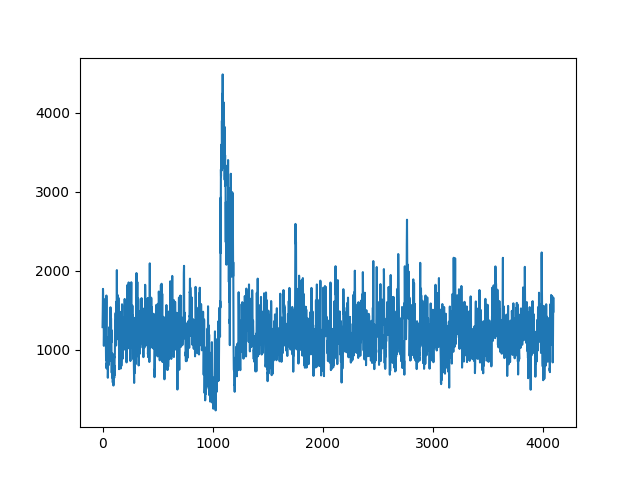

In [35]:
plt.figure()
plt.plot(np.concatenate(hi_dms))

In [31]:
234500 / 4096

57.2509765625

In [8]:
#NSIG = 10
#spec = np.mean(data, axis=0)
#spec[0] = 0  # remove DC bias
#diff = spec.copy()
#diff[1:-1] -= 0.5 * (spec[:-2] + spec[2:])
#nos = spec / (hdr['AccLen'] * data.shape[0])**0.5
#dnos = nos.copy()
#dnos[1:-1] = np.sqrt(dnos[1:-1]**2 + 0.5 * (dnos[:-2]**2 + dnos[2:]**2))
#fmask = (np.divide(diff, dnos, where=dnos > 0) < NSIG)
#for i in range(2):
#    fwgt = fmask.astype('float')
#    freq_fmat = hera_filters.dspec.fit_solution_matrix(np.diag(fwgt), freq_amat)
#    fmdl = dpss_filter(spec * fwgt, freq_amat, freq_fmat)
#    nos = fmdl / (hdr['AccLen'] * data.shape[0])**0.5
#    fmask = (np.divide(spec - fmdl, nos, where=nos > 0) < NSIG)
#fwgt = fmask.astype('float')
#gain = np.sum(data[:,fmask], axis=1, keepdims=False) / np.sum(fmdl[fmask])
#tmdl = np.median(gain)
#tnos = np.sqrt(np.median(np.abs(gain - tmdl)**2))  # XXX not really std
#tmask = (gain - tmdl) / tnos < NSIG  # XXX not really std
#for i in range(2):
#    twgt = tmask.astype('float')
#    time_fmat = hera_filters.dspec.fit_solution_matrix(np.diag(twgt), time_amat)
#    tmdl = dpss_filter(gain * twgt, time_amat, time_fmat)
#    tnos = np.sqrt(np.median(np.abs(gain - tmdl)**2))  # XXX not really std
#    tmask = (gain - tmdl) / tnos < NSIG
#twgt = tmask.astype('float')
#
#mdl = np.outer(tmdl, fmdl)
#nos = mdl / hdr['AccLen']**0.5
#diff_dat = data - mdl
#full_mask = np.where(diff_dat > NSIG * nos, 10, 1)
#full_mask[:, ~fmask] = 0
#full_mask[~tmask] = 0
#diff_dat *= full_mask
#
#CH0, CH1 = 400, 400+1024
#fdmt = limbo.fdmt.FDMT(hdr['freqs'][CH0:CH1], hdr['times'])
#dm_vs_t = fdmt.apply(diff_dat[:, CH0:CH1])

<IPython.core.display.Javascript object>


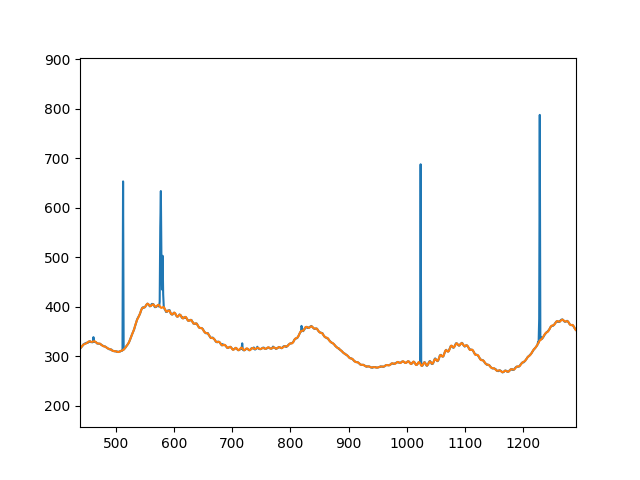

In [9]:
#freqs = hdr['freqs']
freqs = np.arange(hdr['freqs'].size)

plt.figure()
plt.plot(freqs, spec)
plt.plot(freqs, fmdl)
plt.plot(freqs[fmask], (spec - fmdl)[fmask])

In [10]:
#plt.figure()
#plt.plot(hdr['times'], gain - 1)
#plt.plot(hdr['times'], tmdl - 1)
#plt.plot(hdr['times'], gain - tmdl)
#plt.plot(np.fft.rfftfreq(gain.size, hdr['inttime']), np.abs(np.fft.rfft(gain[:,0]-sgain[:,0]))**2)
#plt.plot(np.fft.rfftfreq(gain.size, hdr['inttime']), np.abs(np.fft.rfft(gain[:,0]))**2)

<IPython.core.display.Javascript object>


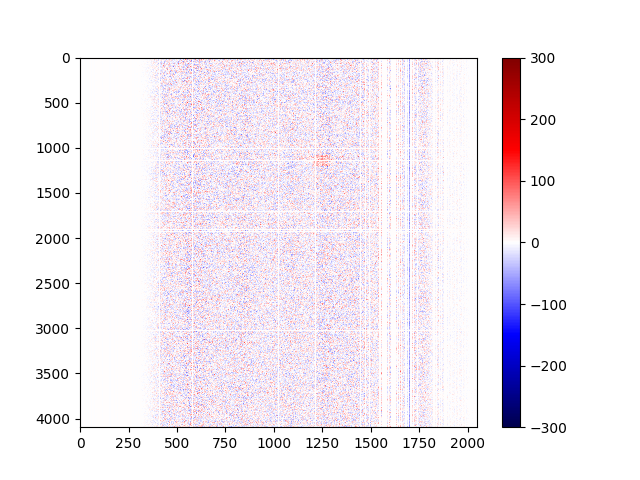

In [36]:
DIFF_SCALE = 300
plt.figure()
#plt.imshow(d, cmap='gist_yarg', aspect='auto', vmax=1000)
#plt.imshow(diff_dat, cmap='seismic', vmax=DIFF_SCALE, vmin=-DIFF_SCALE, aspect='auto', interpolation='nearest')
plt.imshow(diff_dat, cmap='seismic', vmax=DIFF_SCALE, vmin=-DIFF_SCALE, aspect='auto', interpolation='nearest')
#plt.imshow(diff_dat / nos, cmap='seismic', vmax=-5, vmin=5, aspect='auto', interpolation='nearest')
#plt.imshow(nos, cmap='seismic', vmax=DIFF_SCALE, vmin=-DIFF_SCALE, aspect='auto', interpolation='nearest')
plt.colorbar()

<IPython.core.display.Javascript object>


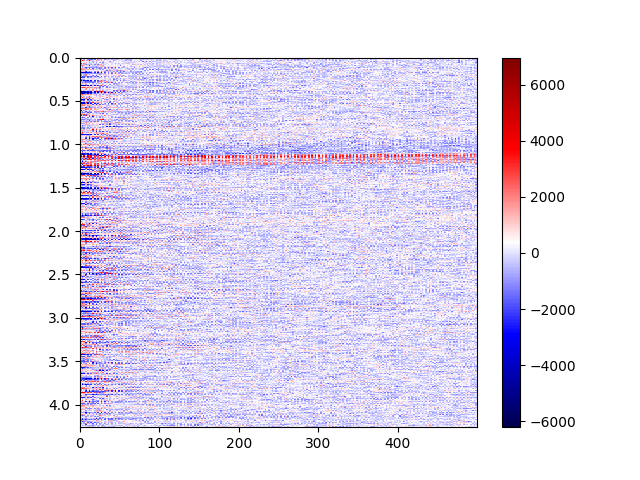

In [37]:
#from matplotlib import colors

plt.figure()
#plt.imshow(dm_vs_t, cmap='jet', norm=colors.LogNorm(vmin=3e3),
plt.imshow(dm_vs_t, cmap='seismic',
           extent=(fdmt.dms[0], fdmt.dms[-1], hdr['times'][-1] - hdr['times'][0], 0),
           aspect='auto', interpolation='nearest')
plt.colorbar()

<IPython.core.display.Javascript object>


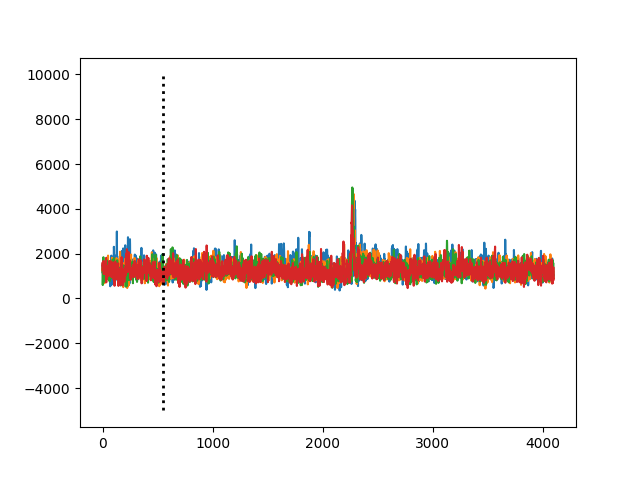

In [28]:
plt.figure()
times = np.arange(hdr['times'].size)
#plt.plot(hdr['times'], np.max(dm_vs_t[:,np.logical_and( 25 > fdmt.dms, fdmt.dms >=  12)], axis=1))
#plt.plot(hdr['times'], np.max(dm_vs_t[:,np.logical_and( 50 > fdmt.dms, fdmt.dms >=  25)], axis=1))
#plt.plot(hdr['times'], np.max(dm_vs_t[:,np.logical_and(100 > fdmt.dms, fdmt.dms >=  50)], axis=1))
plt.plot(times, np.max(dm_vs_t[:,np.logical_and(200 > fdmt.dms, fdmt.dms >= 100)], axis=1))
plt.plot(times, np.max(dm_vs_t[:,np.logical_and(300 > fdmt.dms, fdmt.dms >= 200)], axis=1))
plt.plot(times, np.max(dm_vs_t[:,np.logical_and(400 > fdmt.dms, fdmt.dms >= 300)], axis=1))
plt.plot(times, np.max(dm_vs_t[:,np.logical_and(500 > fdmt.dms, fdmt.dms >= 400)], axis=1))
plt.vlines(times[553], color='k', linestyle='dotted', linewidth=2, ymin=-5e3, ymax=1e4)
#plt.plot(hdr['times'], np.max(dm_vs_t[:,fdmt.dms > 200], axis=1))
#plt.plot(hdr['times'], np.max(dm_vs_t[:,fdmt.dms > 200], axis=1))